## Install libraries

In [2]:
import sys

!{sys.executable} -m pip install --quiet "pandas" "matplotlib" "audiolazy" "midiutil" "numpy" "Pillow"


## Mapping function

In [3]:
import numpy as np  

def map_value(value, min_value, max_value, min_result, max_result, power=1):
    '''maps value(s) from one range to another

    value: input value (int, float, list, or array)
    min_value,max_value: input value range
    min_result,max_result: output value range
    power: scaling parameter, linear mapping if set to 1
    
    Returns:
        int if both min_result and max_result are int, otherwise float
        list of int or float if value is a list
        array of int or float if value is an array'''
    
    value_input = value 
    
    #if list, convert to array
    if isinstance(value_input, list): value = np.array(value_input) 
        
    #validation
    if np.any(value < min_value) or np.any(value > max_value):
        raise ValueError(f'one or more values is outside of range [{min_value},{max_value}]!')
            
    #mapping
    result = min_result + ((value - min_value)/(max_value - min_value))**power*(max_result - min_result)
    
    #rounding
    if isinstance(min_result*max_result, int):
        if isinstance(value_input, int) or isinstance(value_input, float):
            result = round(result)
        if isinstance(value_input, list) or isinstance(value_input, np.ndarray):
            result = np.round(result).astype(int)
    
    # value_input was list, convert result into list
    if isinstance(value_input, list): result = result.tolist() 
        
    return result

##testing
for value in [3, 3., [0,3,10], np.array([0,2, 4, 6, 8, 10])]:  #int, float, list , array
    result_float = map_value(value, 0, 10, 100., 200, power=2)
    result_int = map_value(value, 0, 10, 100, 200, power=2)
    print(result_float, type(result_float))
    print(result_int, type(result_int), '\n')

109.0 <class 'float'>
109 <class 'int'> 

109.0 <class 'float'>
109 <class 'int'> 

[100.0, 109.0, 200.0] <class 'list'>
[100, 109, 200] <class 'list'> 

[100. 104. 116. 136. 164. 200.] <class 'numpy.ndarray'>
[100 104 116 136 164 200] <class 'numpy.ndarray'> 



## Process the image


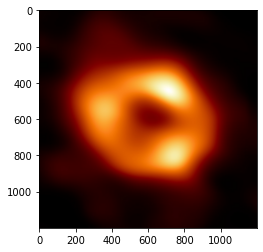

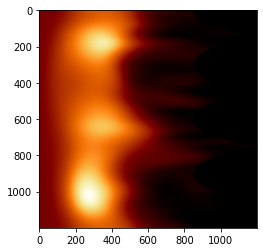

In [9]:
import cv2
import numpy as np
%matplotlib inline 

from matplotlib import pyplot as plt


#read image
source = cv2.imread('black_hole.jpg', 1)
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
plt.show()
#ensure image is of the type float
img = source.astype(np.float32)
 
#Holds the square root of the sum of squares of the image dimensions so that the entire width/height of the original image 
#is used to express the complete circular range of the resulting polar image
value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
#Convert image to polar (transform circular black hole to linear shape)
polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)

polar_image = polar_image.astype(np.uint8)
plt.imshow(cv2.cvtColor(polar_image, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
type(polar_image)
polar_image = polar_image[:,:,::-1]# convert to RGB

In [5]:
from PIL import Image, ImageOps

from matplotlib import cm
im = Image.fromarray(polar_image, 'RGB')

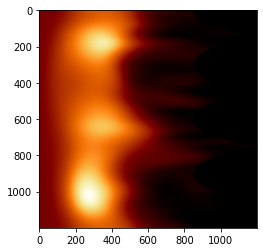

In [6]:
plt.imshow(im) #1200*1200

In [7]:
#flip image vertically, then rotate 90 degs to left to be horizontal
width, height = im.size
im1 = im.crop((0,0,800,1200)) #Crop, reduce the black parts
im1 = im1.rotate(90, Image.NEAREST, expand = 1)
im1 = ImageOps.mirror(im1)

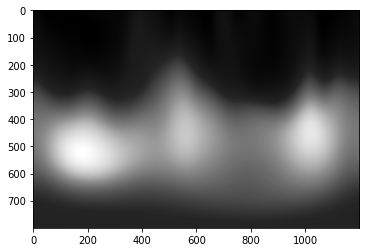

In [8]:
im_grey = im1.convert('L') #convert to greyscale
plt.imshow(im_grey, cmap='gray')
pixels = np.array(im_grey)
min = np.max(pixels)
max = np.min(pixels)

In [26]:
amp = []
power = 2
#Map brightness to amplitude: map 0-255 brightness values to 0-1 amplitude, time goes from left to right
for i, row in enumerate(pixels):
  amp.append([(1/255*val)**power for val in row]) 
amp = np.array(amp)
amp.shape
#amp[a][b] = amplitude for frequency "a at time segment "b"

(800, 1200)

In [27]:
import random
#Map height (Radial position) to freq: map 0-800 pixels to 20-2300 Hz
freqs = map_value(np.array(range(800)), 0, 800, 20, 2300, power=1) #length 800 for 800 rows in the image
freqs = [f+2*(random.random()-0.5) for f in freqs] #randomize them a tiny bit to avoid clicking

# Construct the Audio Wave


In [28]:
import wave
import numpy as np
from IPython.display import Audio
import librosa
import librosa.display
from scipy.io.wavfile import write
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
width = 1200
samplerate = 22050 #Half the typical 44.1kHz sample rate
#1200 columns of pixels --> 20 seconds
#there are 1200 segments containin the amplitudes for each frequency
duration = 20
s = int(duration * samplerate / width) #how many samples per timestamp
t = np.linspace(0, duration, duration*samplerate) #time variable
result =  np.zeros(samplerate*duration) #make empty array
#for every segment, add all functions that correspond to each freq (row on image)
for i in range(1200-1): #for every column or every dt
  
  for n, f in enumerate(freqs):#for every frequency(row)
    #t = np.linspace(i*duration/1200, (i+1)*duration/1200, dt) #np.array(range(i*dt,(i+1)*dt))
    current = np.sin(2 * np.pi * (f) * t[i*s:(i+1)*s])*amp[n][i] #the wave function
    result[i*s:(i+1)*s] += current #add it to the result array
result /= 1600 #Decrease volume
#Audio(result, rate = samplerate)


In [29]:
Audio(result, rate = samplerate)


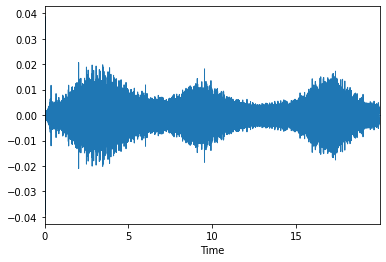

In [31]:
librosa.display.waveplot(result)
#Three peaks correspond to the 3 bright segments in image